In [50]:
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import math
import os

%matplotlib inline

with open("calib/calib_data.json","r") as f:
    j = json.load(f)
j["cameraData"][0][1]
rgb_data=j["cameraData"][1][1]
left_data=j["cameraData"][2][1]
right_data=j["cameraData"][0][1]



(176.0, 176.0)

[[fx,0,cx]\
 [0,fy,cy]\
 [0,0,1]]

74.0 74.0


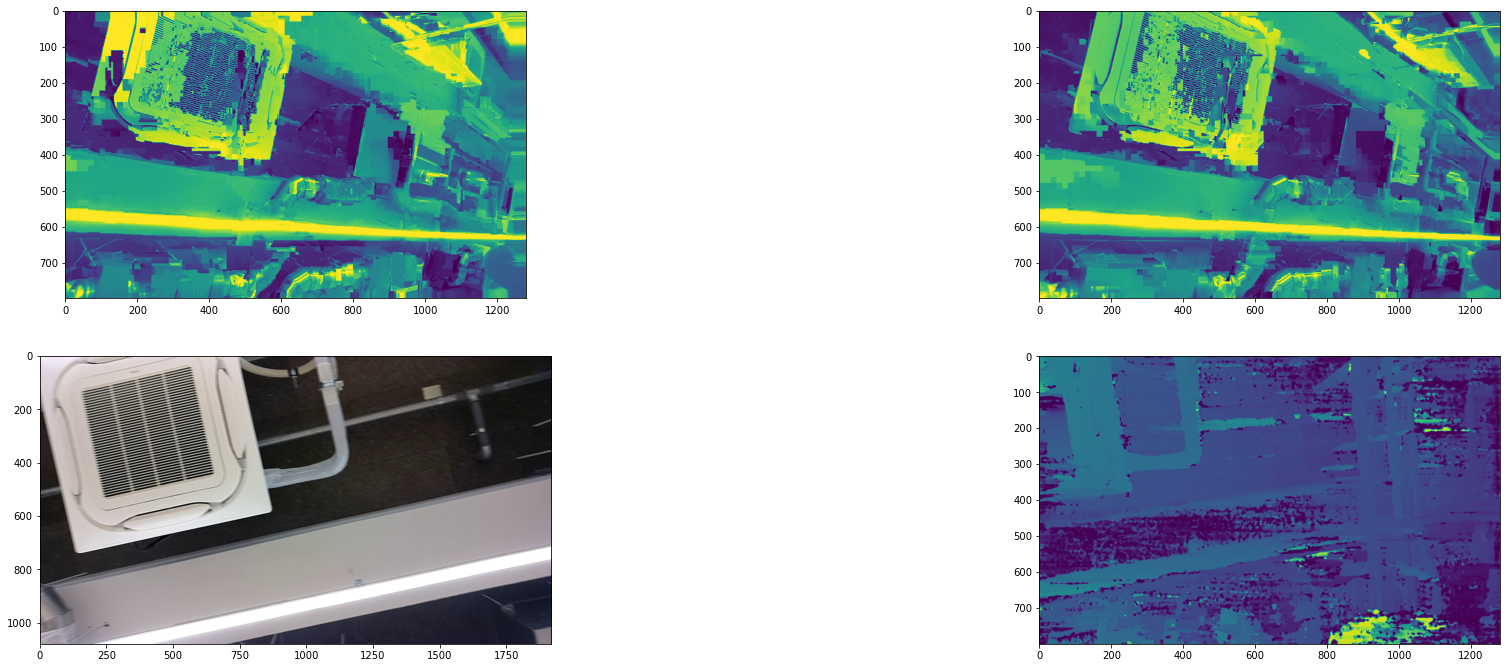

(array([[ 13,  13,  12, ..., 180, 180, 180],
        [ 13,  13,  12, ..., 180, 180, 180],
        [ 13,  13,  12, ..., 180, 180, 180],
        ...,
        [122, 122, 122, ...,  68,  68,  68],
        [122, 122, 122, ...,  68,  68,  68],
        [122, 122, 122, ...,  68,  68,  68]], dtype=uint8),
 array([[ 13,  13,  13, ...,  80,  80,  80],
        [ 13,  13,  13, ...,  80,  80,  80],
        [ 13,  13,  13, ...,  80,  80,  80],
        ...,
        [255, 255, 255, ..., 138, 138, 138],
        [255, 255, 255, ..., 138, 138, 138],
        [255, 255, 255, ..., 138, 138, 138]], dtype=uint8),
 array([[[201, 200, 205],
         [202, 201, 206],
         [203, 202, 207],
         ...,
         [ 22,  21,  24],
         [ 22,  21,  24],
         [ 22,  21,  24]],
 
        [[206, 205, 210],
         [207, 206, 211],
         [209, 208, 213],
         ...,
         [ 22,  21,  24],
         [ 22,  21,  24],
         [ 22,  21,  24]],
 
        [[229, 228, 233],
         [230, 229, 234],
      

In [55]:
directory=5

left_movie = cv2.VideoCapture(f'movie/{directory}/left.mp4')
right_movie = cv2.VideoCapture(f'movie/{directory}/right.mp4')
rgb_movie = cv2.VideoCapture(f'movie/{directory}/rgb.mp4')
disparity = cv2.VideoCapture(f'movie/{directory}/disparity.mp4')
depth = cv2.VideoCapture(f'movie/{directory}/depth.mp4')

print(left_movie.get(cv2.CAP_PROP_FRAME_COUNT),right_movie.get(cv2.CAP_PROP_FRAME_COUNT))
getframes(30,display=True)

In [28]:
def getframes(frame_num,display=False):
    left_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    right_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    rgb_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    disparity.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
#     depth.set(cv2.CAP_PROP_POS_FRAMES,frame_num)

    
    left_ret, left_frame = left_movie.read()
    right_ret, right_frame = right_movie.read()
    rgb_ret,rgb_frame = rgb_movie.read()

    dis_ret,dis_frame = disparity.read()
#     depth_ret,depth_frame = depth.read()


    left_frame =cv2.cvtColor(left_frame, cv2.COLOR_BGR2GRAY)
    right_frame =cv2.cvtColor(right_frame, cv2.COLOR_BGR2GRAY)
    rgb_frame = cv2.cvtColor(rgb_frame,cv2.COLOR_BGRA2RGB)
    dis_frame = cv2.cvtColor(dis_frame,cv2.COLOR_BGR2GRAY)
#     depth_frame = cv2.cvtColor(depth_frame,cv2.COLOR_BGR2GRAY)

    
    if display:
        plt.figure(figsize=(32,18))
        plt.subplot(321).imshow(left_frame,vmin=0, vmax=255)
        plt.subplot(322).imshow(right_frame,vmin=0, vmax=255)
        plt.subplot(323).imshow(rgb_frame)
        plt.subplot(324).imshow(dis_frame)
#         plt.subplot(325).imshow(depth_frame)
        
        plt.show()
    return left_frame,right_frame,rgb_frame,dis_frame

In [3]:
bl = 7.5 #cm base line
rcx = right_data["intrinsicMatrix"][0][2]
rcy = right_data["intrinsicMatrix"][1][2]
rfx = right_data["intrinsicMatrix"][0][0]
rfy = right_data["intrinsicMatrix"][1][1]

rgb_cx=rgb_data["intrinsicMatrix"][0][2]
rgb_cy=rgb_data["intrinsicMatrix"][1][2]
rgb_fx=rgb_data["intrinsicMatrix"][0][0]
rgb_fy=rgb_data["intrinsicMatrix"][1][1]
rgb_data["intrinsicMatrix"]

[[1481.1824951171875, 0.0, 947.2300415039062],
 [0.0, 1479.3084716796875, 545.7195434570312],
 [0.0, 0.0, 1.0]]

In [58]:
def akaze_compute(left_frame,right_frame,display=False):
    akaze = cv2.AKAZE_create() 
    akaze_left_kp, akaze_left_des = akaze.detectAndCompute(left_frame,None)
    akaze_right_kp, akaze_right_des = akaze.detectAndCompute(right_frame,None)
    akaze_bf = cv2.BFMatcher(crossCheck=True)
    akaze_matches = akaze_bf.match(akaze_left_des, akaze_right_des)
    akaze_matches = [i for i in akaze_matches if abs(akaze_left_kp[i.queryIdx].pt[1]-akaze_right_kp[i.trainIdx].pt[1])<10]
    if display:
        print(len(akaze_matches),"matches found")
        img_akaze = cv2.drawMatches(left_frame, akaze_left_kp, right_frame,akaze_right_kp, akaze_matches, None, flags=2)
        plt.figure(figsize=(32,9))
        plt.imshow(img_akaze)
        plt.show()
    return akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches

2729 matches found


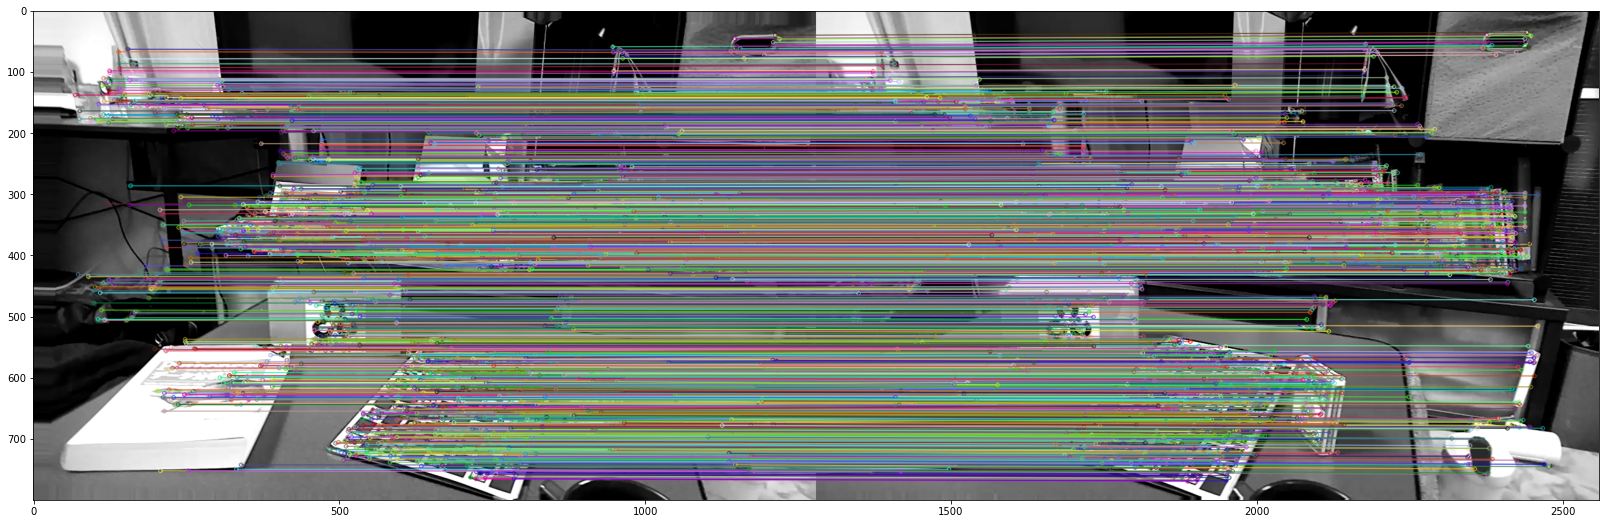

In [59]:
left_frame,right_frame,rgb_frame,dis_frame,conf_frame =getframes(30)
akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches=akaze_compute(left_frame,right_frame,display=True)

In [60]:
def make_pcd(rgb_frame,dis_frame,conf_frame,filename,display=False):
    pointlist=[]
    colors=[]
    for xr in range(dis_frame.shape[0]):
        for yr in range(dis_frame.shape[1]):
            if conf_frame[xr][yr]<100 and dis_frame[xr][yr]>16and dis_frame[xr][yr]<96:
                d = dis_frame[xr][yr]
                z=rfx*bl/d
                x= (rcx-xr)*bl/d
                y= (rcy-yr)*bl/d
                rgbx=int(rgb_cx-(x+3.5)*rgb_fx/z)
                rgby=int(rgb_cy-y*rgb_fy/z)
                if rgbx>=0 and rgby>=0:
                    try :
                        color = rgb_frame[rgbx][rgby]/256
                        colors.append(color)
                        p=[x,y,z]
                        pointlist.append(p)
                    except IndexError:
                        pass
    pointlist=np.asarray(pointlist)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(pointlist))
    pcd.colors= o3d.utility.Vector3dVector(np.array(colors))
    o3d.io.write_point_cloud(f"{filename}.ply", pcd)
    if display:
        o3d.visualization.draw_geometries([pcd])

In [46]:
make_pcd(rgb_frame,dis_frame,conf_frame,"./fpcd")

In [61]:
def akaze_3d_position(akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches):
    positions = []
    right_descriptions = []
    right_kp = []
    for match in akaze_matches:
        left_ind=match.queryIdx
        right_ind=match.trainIdx
        left_pt=akaze_left_kp[left_ind].pt
        right_pt=akaze_right_kp[right_ind].pt
        d = left_pt[0]-right_pt[0]
        z=rfx*bl/d
        x= (rcx-right_pt[1])*bl/d
        y=(rcy-right_pt[0])*bl/d
        position=[x,y,z]
        description =akaze_right_des[right_ind]
        positions.append(position)
        right_descriptions.append(description)
        right_kp.append(akaze_right_kp[right_ind].pt)
    positions = np.asarray(positions)
    right_descriptions=np.asarray(right_descriptions)
    right_kp=np.asarray(right_kp)
    return positions,right_descriptions,right_kp

In [99]:
positions,right_descriptions,right_kp=akaze_3d_position(akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches)
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(positions)
pcd2.colors = o3d.utility.Vector3dVector(np.tile([1,0,0],[positions.shape[0],1]))
o3d.io.write_point_cloud("akazepcd.ply", pcd2)

True

In [100]:
fragment = o3d.io.read_point_cloud("./fpcd.ply")
fragment2 = o3d.io.read_point_cloud("./akazepcd.ply")
allp=np.asarray(fragment.points)
allc=np.asarray(fragment.colors)
allp2=np.asarray(fragment2.points)
allc2=np.asarray(fragment2.colors)
p=np.concatenate([allp,allp2])
c=np.concatenate([allc,allc2])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(p)
pcd.colors = o3d.utility.Vector3dVector(c)
o3d.io.write_point_cloud("./newfpcd.ply", pcd)

True

2729 matches found


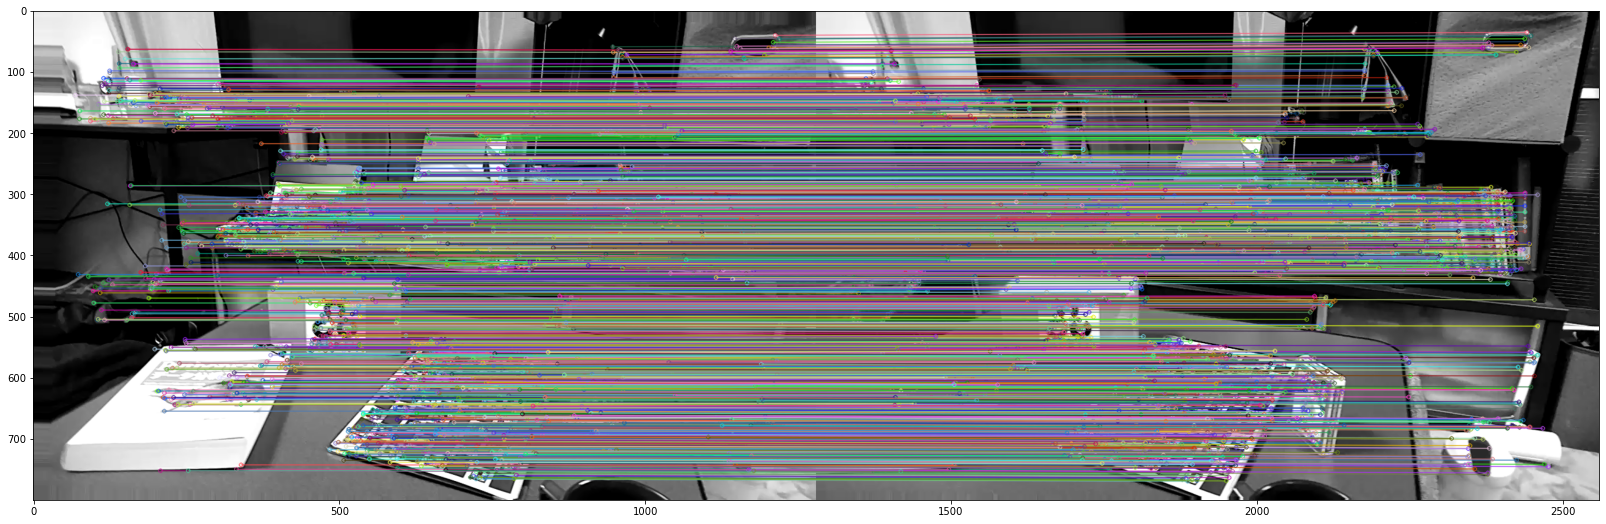

In [62]:
left_frame,right_frame,rgb_frame,dis_frame,conf_frame =getframes(30)
akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches=akaze_compute(left_frame,right_frame,display=True)
positions,right_descriptions,right_kp=akaze_3d_position(akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches)

2608 matches found


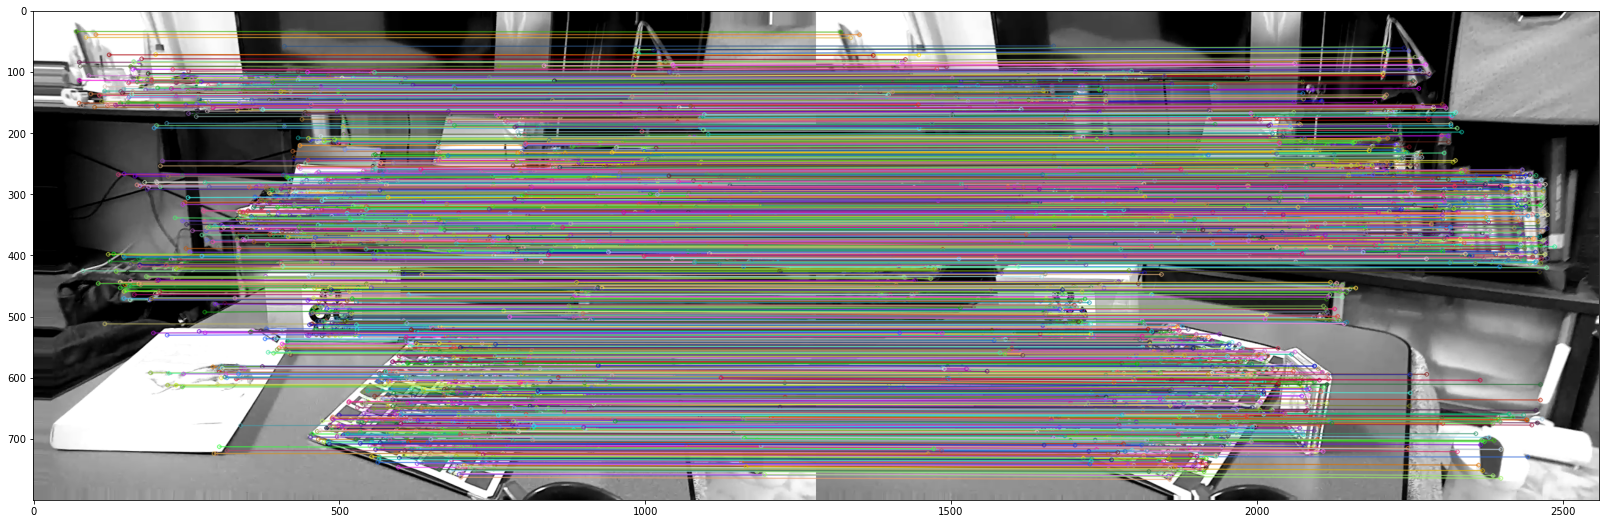

In [68]:
next_left_frame,next_right_frame,next_rgb_frame,next_dis_frame,next_conf_frame =getframes(45)
next_akaze_left_kp, next_akaze_left_des,next_akaze_right_kp, next_akaze_right_des,next_akaze_matches=akaze_compute(next_left_frame,next_right_frame,display=True)
next_positions,next_right_descriptions,next_right_kp=akaze_3d_position(next_akaze_left_kp, next_akaze_left_des,next_akaze_right_kp, next_akaze_right_des,next_akaze_matches)

2729


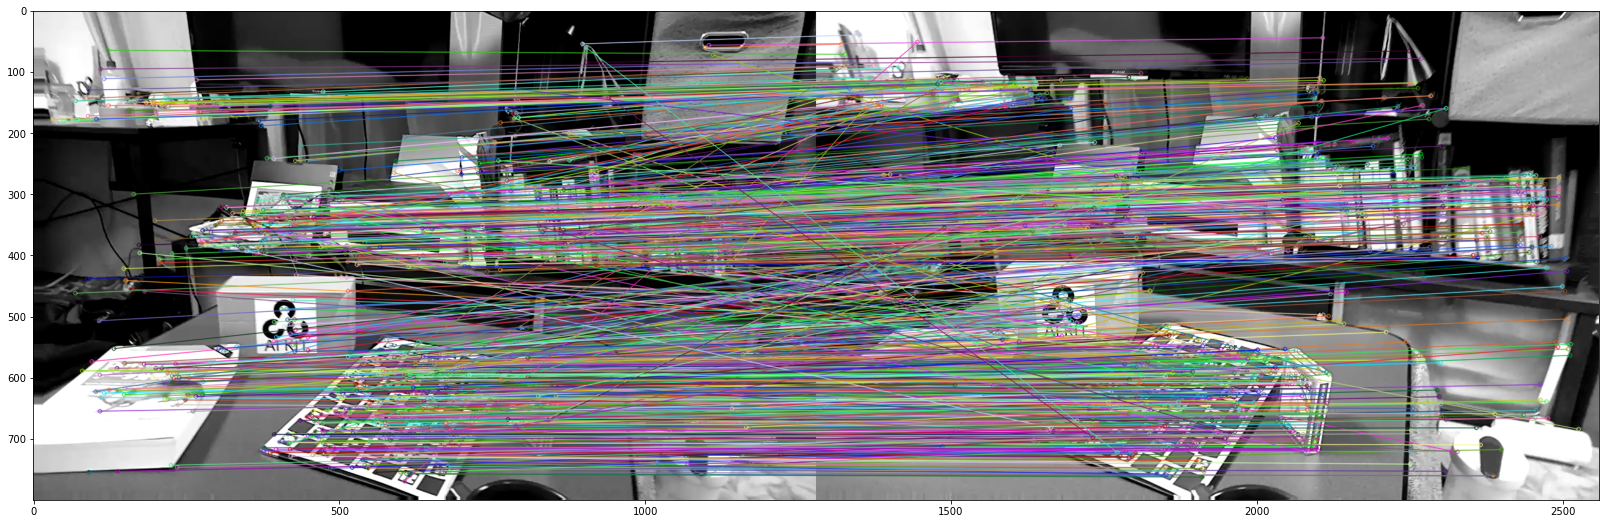

In [89]:
good_matches=match_by_frame(right_descriptions,next_right_descriptions)
print(len(good_matches))
img3 = cv2.drawMatches(right_frame,akaze_right_kp,next_right_frame,next_akaze_right_kp,good_matches[:1000], None,flags=2)
plt.figure(figsize=(32,9))
plt.imshow(img3)

In [7]:
frame_count=int(left_movie.get(cv2.CAP_PROP_FRAME_COUNT))
for f in range(1293):
    print(f"now running frame {f}")
    left_frame,right_frame,rgb_frame,dis_frame,conf_frame =getframes(f)
    akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches=akaze_compute(left_frame,right_frame)
    positions,right_descriptions,right_kp=akaze_3d_position(akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches)
    os.mkdir(f"./frame/{str(f)}")
    make_pcd(rgb_frame,dis_frame,conf_frame,f"./frame/{str(f)}/color")
    np.savez(f"./frame/{str(f)}/pos_des_kp_frame",positions=positions,right_descriptions=right_descriptions,right_kp=right_kp,right_frame=right_frame)


now running frame 0
now running frame 1
now running frame 2
now running frame 3
now running frame 4
now running frame 5
now running frame 6
now running frame 7
now running frame 8
now running frame 9
now running frame 10
now running frame 11
now running frame 12
now running frame 13
now running frame 14
now running frame 15
now running frame 16
now running frame 17
now running frame 18
now running frame 19
now running frame 20
now running frame 21
now running frame 22
now running frame 23
now running frame 24
now running frame 25
now running frame 26
now running frame 27
now running frame 28
now running frame 29
now running frame 30
now running frame 31
now running frame 32
now running frame 33
now running frame 34
now running frame 35
now running frame 36
now running frame 37
now running frame 38
now running frame 39
now running frame 40
now running frame 41
now running frame 42
now running frame 43
now running frame 44
now running frame 45
now running frame 46
now running frame 47
no

now running frame 378
now running frame 379
now running frame 380
now running frame 381
now running frame 382
now running frame 383
now running frame 384
now running frame 385
now running frame 386
now running frame 387
now running frame 388
now running frame 389
now running frame 390
now running frame 391
now running frame 392
now running frame 393
now running frame 394
now running frame 395
now running frame 396
now running frame 397
now running frame 398
now running frame 399
now running frame 400
now running frame 401
now running frame 402
now running frame 403
now running frame 404
now running frame 405
now running frame 406
now running frame 407
now running frame 408
now running frame 409
now running frame 410
now running frame 411
now running frame 412
now running frame 413
now running frame 414
now running frame 415
now running frame 416
now running frame 417
now running frame 418
now running frame 419
now running frame 420
now running frame 421
now running frame 422
now runnin

now running frame 751
now running frame 752
now running frame 753
now running frame 754
now running frame 755
now running frame 756
now running frame 757
now running frame 758
now running frame 759
now running frame 760
now running frame 761
now running frame 762
now running frame 763
now running frame 764
now running frame 765
now running frame 766
now running frame 767
now running frame 768
now running frame 769
now running frame 770
now running frame 771
now running frame 772
now running frame 773
now running frame 774
now running frame 775
now running frame 776
now running frame 777
now running frame 778
now running frame 779
now running frame 780
now running frame 781
now running frame 782
now running frame 783
now running frame 784
now running frame 785
now running frame 786
now running frame 787
now running frame 788
now running frame 789
now running frame 790
now running frame 791
now running frame 792
now running frame 793
now running frame 794
now running frame 795
now runnin

now running frame 1119
now running frame 1120
now running frame 1121
now running frame 1122
now running frame 1123
now running frame 1124
now running frame 1125
now running frame 1126
now running frame 1127
now running frame 1128
now running frame 1129
now running frame 1130
now running frame 1131
now running frame 1132
now running frame 1133
now running frame 1134
now running frame 1135
now running frame 1136
now running frame 1137
now running frame 1138
now running frame 1139
now running frame 1140
now running frame 1141
now running frame 1142
now running frame 1143
now running frame 1144
now running frame 1145
now running frame 1146
now running frame 1147
now running frame 1148
now running frame 1149
now running frame 1150
now running frame 1151
now running frame 1152
now running frame 1153
now running frame 1154
now running frame 1155
now running frame 1156
now running frame 1157
now running frame 1158
now running frame 1159
now running frame 1160
now running frame 1161
now running

In [33]:
np.load("./frame/0/pos_des_kp_frame.npz").files

['positions', 'right_descriptions', 'right_kp', 'right_frame']

In [79]:
def match_by_frame(t1_descriptions,t2_descriptions):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(t1_descriptions,t2_descriptions, k=2)
    ratio = 0.5
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    return good_matches

In [83]:
def match_by_frame(t1_descriptions,t2_descriptions):
    bf = cv2.BFMatcher()
    matches = bf.match(t1_descriptions,t2_descriptions)
    good_matches = sorted(matches, key=lambda x: x.distance)
    return good_matches

In [14]:
def gause(x):
    y=1/math.sqrt(2*math.pi)*np.exp(-((x/100)**2)/2)
    return y

In [17]:
gause(300)

0.0044318484119380075

In [37]:
def affinM(t1_positions,t2_positions,good_matches):
    t1_3d_points=[]
    t2_3d_points=[]
    confidence = []
    for match in good_matches:
        t1_3d_points.append(t1_positions[match.queryIdx])
        t2_3d_points.append(t2_positions[match.trainIdx])
        c = gause(match.distance)
        confidence.append([c,c,c])
    t1_3d_points=np.array(t1_3d_points)
    t2_3d_points=np.array(t2_3d_points)
    confidence=np.array(confidence)
    Y0 =np.sum(t1_3d_points*confidence,axis=0)/np.sum(confidence,axis=0)
    X0 =np.sum(t2_3d_points*confidence,axis=0)/np.sum(confidence,axis=0)
    # scale 
    # math.sqrt(np.sum(np.diag(((t1_3d_points-Y0)*confidence)@(t1_3d_points-Y0).T))/np.sum(np.diag(((t2_3d_points-X0)*confidence)@(t2_3d_points-X0).T)))
    H = (t2_3d_points-X0).T@(t1_3d_points-Y0)
    U, s, V = np.linalg.svd(H, full_matrices=True)
    R=(V@U).T
    T=Y0-R@X0
    M=np.array([
        [R[0][0],R[0][1],R[0][2],T[0]],
        [R[1][0],R[1][1],R[1][2],T[1]],
        [R[2][0],R[2][1],R[2][2],T[2]],
        [0,0,0,1]
    ])
    return M

In [91]:
t1=np.load("./frame/100/pos_des_kp_frame.npz")
t1_positions=t1['positions']
t1_des=t1['right_descriptions']

t2=np.load("./frame/130/pos_des_kp_frame.npz")
t2_positions=t2['positions']
t2_des=t2['right_descriptions']

good_matches=match_by_frame(t1_des,t2_des)
print(len(good_matches))
M=affinM(t1_positions,t2_positions,good_matches)

homo_points=np.concatenate([t2_positions,np.ones((t2_positions.shape[0],1))],1).T
newp=(M@homo_points).T[:,:-1]

good_matches=match_by_frame(t1_des,t2_des)
print(len(good_matches))
M=affinM(t1_positions,newp,good_matches)

homox=np.array([[X0[0]],
                [X0[1]],
                [X0[2]],
                [  1  ]])

homo2=np.array([[t2_positions[30][0]],
                [t2_positions[30][1]],
                [t2_positions[30][2]],
                [  1  ]])
X0,Y0,(M@homox).T,t1_3d_points[30],t2_3d_points[30],(M@homo2).T

712
712


(array([ 49.83764062,  -0.37303405, 128.71928987]),
 array([ 49.7071302 ,   0.37201594, 128.9294904 ]),
 array([[ 50.07006544,  -1.6404289 , 129.89668007,   1.        ]]),
 array([ 14.9572753 , -23.06078254, 129.10708399]),
 array([ 14.8653617 , -23.7295064 , 127.39067034]),
 array([[ 12.01425225, -17.78660031, 122.06044663,   1.        ]]))

In [57]:
t1pcd = o3d.geometry.PointCloud()
t1pcd.points = o3d.utility.Vector3dVector(t1_3d_points)
t1pcd.colors= o3d.utility.Vector3dVector(np.tile([1,0,0],[t1_3d_points.shape[0],1]))
# 赤 合わせたい先

t2pcd = o3d.geometry.PointCloud()
t2pcd.points = o3d.utility.Vector3dVector(t2_3d_points)
t2pcd.colors= o3d.utility.Vector3dVector(np.tile([0,1,0],[t2_3d_points.shape[0],1]))
# 緑 移動前

t3pcd = o3d.geometry.PointCloud()
t3pcd.points = o3d.utility.Vector3dVector(newp)
t3pcd.colors= o3d.utility.Vector3dVector(np.tile([0,0,1],[newp.shape[0],1]))
# 青 移動後

o3d.visualization.draw_geometries([t1pcd,t2pcd,t3pcd])

In [45]:
Mlist=[]
last_frame_position=np.array([])
last_frame_descriptions=np.array([])
numberofappearrence=[]
for i in range(1290):
    print("Now cal : ",i)
    t1=np.load(f"./frame/{str(i)}/pos_des_kp_frame.npz")
    t1_positions=t1['positions']
    t1_descriptions=t1['right_descriptions']
    if i == 0:
        last_frame_position= t1_positions
        last_frame_descriptions=t1_descriptions
    else:
        good_matches=match_by_frame(last_frame_descriptions,t1_descriptions)
        matched_ind = [match.trainIdx for match in good_matches]
        print(len(good_matches)," matches")
        if len(matched_ind)<100:
            M = Mlist[-1]
        else:
            M=affinM(last_frame_position,t1_positions,good_matches)
        homo_points=np.concatenate([t1_positions,np.ones((t1_positions.shape[0],1))],1).T
        t1_positions=(M@homo_points).T[:,:-1]
        new_last_position=[]
        for ind in range(t1_descriptions.shape[0]):
            if ind in matched_ind:
                ind_in_match_ind = matched_ind.index(ind)
                last_p=last_frame_position[good_matches[ind_in_match_ind].queryIdx]
                new_p=(last_p*i+t1_positions[ind])/(i+1)
                new_last_position.append(new_p)
            else:
                new_last_position.append(t1_positions[ind])
        last_frame_descriptions=t1_descriptions
#         last_frame_position=np.asarray(new_last_position)
        last_frame_position=t1_positions
        Mlist.append(M)

Now cal :  0
Now cal :  1
269  matches
Now cal :  2
197  matches
Now cal :  3
226  matches
Now cal :  4
248  matches
Now cal :  5
233  matches
Now cal :  6
241  matches
Now cal :  7
229  matches
Now cal :  8
25  matches
Now cal :  9
0  matches
Now cal :  10
461  matches
Now cal :  11
591  matches
Now cal :  12
639  matches
Now cal :  13
629  matches
Now cal :  14
658  matches
Now cal :  15
651  matches
Now cal :  16
653  matches
Now cal :  17
638  matches
Now cal :  18
629  matches
Now cal :  19
742  matches
Now cal :  20
796  matches
Now cal :  21
853  matches
Now cal :  22
838  matches
Now cal :  23
795  matches
Now cal :  24
830  matches
Now cal :  25
884  matches
Now cal :  26
838  matches
Now cal :  27
924  matches
Now cal :  28
871  matches
Now cal :  29
726  matches
Now cal :  30
742  matches
Now cal :  31
817  matches
Now cal :  32
899  matches
Now cal :  33
854  matches
Now cal :  34
844  matches
Now cal :  35
897  matches
Now cal :  36
809  matches
Now cal :  37
833  matches


Now cal :  313
128  matches
Now cal :  314
170  matches
Now cal :  315
82  matches
Now cal :  316
277  matches
Now cal :  317
254  matches
Now cal :  318
188  matches
Now cal :  319
95  matches
Now cal :  320
84  matches
Now cal :  321
197  matches
Now cal :  322
206  matches
Now cal :  323
211  matches
Now cal :  324
139  matches
Now cal :  325
251  matches
Now cal :  326
266  matches
Now cal :  327
277  matches
Now cal :  328
224  matches
Now cal :  329
240  matches
Now cal :  330
241  matches
Now cal :  331
287  matches
Now cal :  332
281  matches
Now cal :  333
219  matches
Now cal :  334
235  matches
Now cal :  335
254  matches
Now cal :  336
263  matches
Now cal :  337
228  matches
Now cal :  338
238  matches
Now cal :  339
212  matches
Now cal :  340
229  matches
Now cal :  341
251  matches
Now cal :  342
240  matches
Now cal :  343
244  matches
Now cal :  344
307  matches
Now cal :  345
267  matches
Now cal :  346
294  matches
Now cal :  347
270  matches
Now cal :  348
195  mat

332  matches
Now cal :  618
281  matches
Now cal :  619
276  matches
Now cal :  620
386  matches
Now cal :  621
293  matches
Now cal :  622
326  matches
Now cal :  623
305  matches
Now cal :  624
350  matches
Now cal :  625
308  matches
Now cal :  626
182  matches
Now cal :  627
261  matches
Now cal :  628
277  matches
Now cal :  629
197  matches
Now cal :  630
137  matches
Now cal :  631
210  matches
Now cal :  632
118  matches
Now cal :  633
244  matches
Now cal :  634
255  matches
Now cal :  635
288  matches
Now cal :  636
251  matches
Now cal :  637
223  matches
Now cal :  638
248  matches
Now cal :  639
201  matches
Now cal :  640
236  matches
Now cal :  641
223  matches
Now cal :  642
138  matches
Now cal :  643
75  matches
Now cal :  644
115  matches
Now cal :  645
57  matches
Now cal :  646
60  matches
Now cal :  647
69  matches
Now cal :  648
162  matches
Now cal :  649
238  matches
Now cal :  650
268  matches
Now cal :  651
225  matches
Now cal :  652
177  matches
Now cal :  

140  matches
Now cal :  918
155  matches
Now cal :  919
182  matches
Now cal :  920
165  matches
Now cal :  921
165  matches
Now cal :  922
125  matches
Now cal :  923
156  matches
Now cal :  924
151  matches
Now cal :  925
148  matches
Now cal :  926
184  matches
Now cal :  927
172  matches
Now cal :  928
148  matches
Now cal :  929
137  matches
Now cal :  930
149  matches
Now cal :  931
128  matches
Now cal :  932
144  matches
Now cal :  933
146  matches
Now cal :  934
121  matches
Now cal :  935
215  matches
Now cal :  936
150  matches
Now cal :  937
197  matches
Now cal :  938
143  matches
Now cal :  939
167  matches
Now cal :  940
201  matches
Now cal :  941
173  matches
Now cal :  942
152  matches
Now cal :  943
195  matches
Now cal :  944
236  matches
Now cal :  945
245  matches
Now cal :  946
216  matches
Now cal :  947
127  matches
Now cal :  948
193  matches
Now cal :  949
174  matches
Now cal :  950
166  matches
Now cal :  951
137  matches
Now cal :  952
80  matches
Now cal 

215  matches
Now cal :  1218
107  matches
Now cal :  1219
79  matches
Now cal :  1220
195  matches
Now cal :  1221
265  matches
Now cal :  1222
239  matches
Now cal :  1223
173  matches
Now cal :  1224
266  matches
Now cal :  1225
376  matches
Now cal :  1226
436  matches
Now cal :  1227
344  matches
Now cal :  1228
112  matches
Now cal :  1229
107  matches
Now cal :  1230
248  matches
Now cal :  1231
108  matches
Now cal :  1232
156  matches
Now cal :  1233
234  matches
Now cal :  1234
220  matches
Now cal :  1235
124  matches
Now cal :  1236
65  matches
Now cal :  1237
111  matches
Now cal :  1238
131  matches
Now cal :  1239
295  matches
Now cal :  1240
81  matches
Now cal :  1241
155  matches
Now cal :  1242
192  matches
Now cal :  1243
178  matches
Now cal :  1244
169  matches
Now cal :  1245
326  matches
Now cal :  1246
351  matches
Now cal :  1247
355  matches
Now cal :  1248
525  matches
Now cal :  1249
586  matches
Now cal :  1250
514  matches
Now cal :  1251
443  matches
Now 

In [252]:
def showaffinM(M):
    r=M[:3,:3]
    print(r)
    t=M[:3,3:]
    print(t.T)
for i in range(1280):
    showaffinM(Mlist[i])

[[-0.44407262 -0.60343569 -0.84541131]]
[[-0.24105816 -0.11773972 -0.28382927]]
[[-2.83207889  1.19043974  0.04005133]]
[[-0.72313432 -0.06754061  0.73669063]]
[[ 0.00148698 -0.0207783   1.14104206]]
[[ 0.26040309 -0.6331432   1.14604903]]
[[ 1.48135954 -2.10760582 -0.66871837]]
[[ 1.48135954 -2.10760582 -0.66871837]]
[[ 1.48135954 -2.10760582 -0.66871837]]
[[-1.32996607 -1.49998991  0.18054105]]
[[-0.32757319 -1.31388933 -0.06779839]]
[[ 0.22492887 -1.42205356 -0.16250941]]
[[ 0.6479731  -1.25956645 -0.09008498]]
[[ 5.84142818e-01 -1.87384993e+00  1.21648190e-03]]
[[ 0.23803898 -1.9254595   0.12041954]]
[[ 0.05803644 -2.03218717  0.15292492]]
[[ 0.15047843 -2.38088358  0.28062822]]
[[-0.02481653 -2.447935    0.28339032]]
[[-0.34420511 -2.34903937  0.3680559 ]]
[[-0.20958967 -2.53834001  0.422045  ]]
[[-0.38366738 -2.41683612  0.30307005]]
[[-0.56443315 -2.32722008  0.22336201]]
[[-6.57398472e-04 -2.54778505e+00 -2.10001722e-01]]
[[-0.44711609 -1.9709838  -0.18385378]]
[[-0.82374288 -2

[[ 63.00374179 -72.34339784  25.92359132]]
[[ 62.0138764  -70.5057727   25.79400608]]
[[ 65.84499954 -69.85358899  24.26645497]]
[[ 62.86005424 -69.72643052  24.98443219]]
[[ 57.22172062 -67.41412727  26.34858445]]
[[ 60.4330942  -63.46290661  24.53784169]]
[[ 62.3612928  -63.11097821  23.78992515]]
[[ 62.48908246 -63.75739748  23.59855501]]
[[ 63.70131792 -64.82569885  23.13604823]]
[[ 58.3935252  -63.19678686  23.8318835 ]]
[[ 59.48487076 -61.49851583  22.53594826]]
[[ 57.90930721 -61.89518215  23.04504413]]
[[ 57.90930721 -61.89518215  23.04504413]]
[[ 57.90930721 -61.89518215  23.04504413]]
[[ 59.03302807 -57.70328746  21.70658971]]
[[ 60.4628827  -58.30975237  20.72225331]]
[[ 63.85842398 -60.01477627  19.68676202]]
[[ 63.18129332 -63.77483043  20.53965906]]
[[ 60.25480534 -65.14240085  21.94857018]]
[[ 57.39403213 -66.32227549  24.08699354]]
[[ 56.47605503 -66.74135969  24.81790334]]
[[ 56.40771479 -65.97253071  25.23411335]]
[[ 58.24844207 -64.51320343  25.47283087]]
[[ 52.70551

In [46]:
Mlist=np.asarray(Mlist)
np.save("affin_list",Mlist)

In [112]:
pcd = o3d.io.read_point_cloud("./frame/0/color.ply")
points=np.asarray(pcd.points)
homo_points=np.concatenate([points,np.ones((points.shape[0],1))],1)
new_points=(newM@homo_points.T).T[:,:-1]
colors=np.asarray(pcd.colors)


In [293]:
pointlist=[]
colorlist=[]
lastp=np.array([0,0,0,1])
i=0
s=1/(Mlist.shape[0])
for m in Mlist:
    pointlist.append((m@lastp)[:3])
#     print((m@lastp)[:3])
    i+=s
    if i>1:
        i=0
    
    color=np.array([i,0,0])
    colorlist.append(color)
    
pointlist=np.asarray(pointlist)
colorlist=np.asarray(colorlist)

all_pcd = o3d.geometry.PointCloud()
all_pcd.points = o3d.utility.Vector3dVector(pointlist)
all_pcd.colors= o3d.utility.Vector3dVector(colorlist)
o3d.io.write_point_cloud("./m.ply", all_pcd)

True

In [1]:
all_points=None
all_colors=None
for i in range(3):
    pcd = o3d.io.read_point_cloud(f"./frame/{str(i)}/color.ply")
    points=np.asarray(pcd.points)
    homo_points=np.concatenate([points,np.ones((points.shape[0],1))],1).T
    colors=np.asarray(pcd.colors)
    if i==0:
        all_points=homo_points.T[:,:-1]
        all_colors=colors
    else:
        print("adding frame :",i)
        new_points=(Mlist[i-1]@homo_points).T[:,:-1]
        all_points=np.concatenate([all_points,new_points])
        all_colors= np.concatenate([all_colors,colors])
all_pcd = o3d.geometry.PointCloud()
all_pcd.points = o3d.utility.Vector3dVector(all_points)
all_pcd.colors= o3d.utility.Vector3dVector(all_colors)
o3d.io.write_point_cloud("./test2.ply", all_pcd)

NameError: name 'o3d' is not defined

In [270]:
all_points=None
all_colors=None
for i in range(Mlist.shape[0]):
    if i==0 or i%30==0:
        pcd = o3d.io.read_point_cloud(f"./frame/{str(i)}/color.ply")
        points=np.asarray(pcd.points)
        homo_points=np.concatenate([points,np.ones((points.shape[0],1))],1).T
        colors=np.asarray(pcd.colors)
        if i==0:
            all_points=homo_points.T[:,:-1]
            all_colors=colors
        elif i%30==0:
            print("adding frame :",i)
            new_points=(Mlist[i-1]@homo_points).T[:,:-1]
            all_points=np.concatenate([all_points,new_points])
            all_colors= np.concatenate([all_colors,colors])


adding frame : 30
adding frame : 60
adding frame : 90
adding frame : 120
adding frame : 150
adding frame : 180
adding frame : 210
adding frame : 240
adding frame : 270
adding frame : 300
adding frame : 330
adding frame : 360
adding frame : 390
adding frame : 420
adding frame : 450
adding frame : 480
adding frame : 510
adding frame : 540
adding frame : 570
adding frame : 600
adding frame : 630
adding frame : 660
adding frame : 690
adding frame : 720
adding frame : 750
adding frame : 780
adding frame : 810
adding frame : 840
adding frame : 870
adding frame : 900
adding frame : 930
adding frame : 960
adding frame : 990
adding frame : 1020
adding frame : 1050
adding frame : 1080
adding frame : 1110
adding frame : 1140
adding frame : 1170
adding frame : 1200
adding frame : 1230
adding frame : 1260


In [271]:
all_pcd = o3d.geometry.PointCloud()
all_pcd.points = o3d.utility.Vector3dVector(all_points)
all_pcd.colors= o3d.utility.Vector3dVector(all_colors)
o3d.io.write_point_cloud("./all_points.ply", all_pcd)

True

438


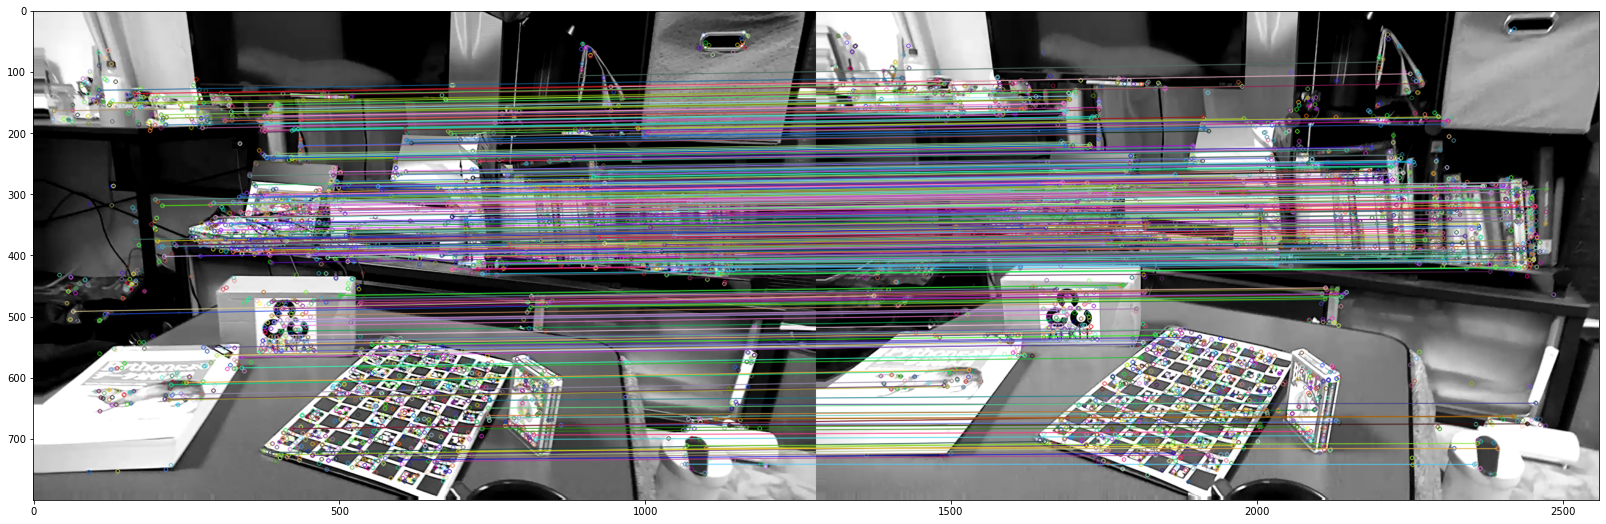

In [76]:

bf = cv2.BFMatcher()
next_matches = bf.knnMatch(right_descriptions,next_right_descriptions, k=2)
ratio = 0.5
next_good = []
for m, n in next_matches:
    if m.distance < ratio * n.distance:
        next_good.append([m])
next_good = sorted(next_good, key=lambda x: x[0].distance)
print(len(next_good))
result_img = cv2.drawMatchesKnn(right_frame,right_kp, next_right_frame,next_right_kp, next_good, None)
img_matching = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(32,9))
plt.imshow(result_img)
plt.show()

In [77]:
pre_3d_points=[]
next_3d_points = []
confidence = []
for match in next_good:
    pre_3d_points.append(positions[match[0].queryIdx])
    next_3d_points.append(next_positions[match[0].trainIdx])
    c = gause(match[0].distance)
    confidence.append([c,c,c])
pre_3d_points=np.array(pre_3d_points)
next_3d_points=np.array(next_3d_points)
confidence=np.array(confidence)

In [78]:
confidence

array([[3.55745913e-01, 3.55745913e-01, 3.55745913e-01],
       [2.53412030e-01, 2.53412030e-01, 2.53412030e-01],
       [2.22519945e-01, 2.22519945e-01, 2.22519945e-01],
       ...,
       [8.63216889e-11, 8.63216889e-11, 8.63216889e-11],
       [7.87975993e-11, 7.87975993e-11, 7.87975993e-11],
       [3.78217244e-11, 3.78217244e-11, 3.78217244e-11]])

In [79]:
Y0 =np.sum(pre_3d_points*confidence,axis=0)/np.sum(confidence,axis=0)
X0 =np.sum(next_3d_points*confidence,axis=0)/np.sum(confidence,axis=0)
Y0,X0

(array([-19.48052252,  16.15507799, 142.99856227]),
 array([-22.70821048,  18.85754688, 141.37853092]))

In [80]:
H = (pre_3d_points-np.tile(Y0,[pre_3d_points.shape[0],1])).T@((next_3d_points-np.tile(X0,[next_3d_points.shape[0],1])))
U, s, V = np.linalg.svd(H, full_matrices=True)
R=V@U
T = Y0-R@X0
R,T

(array([[ 0.99941741,  0.03411128, -0.00112527],
        [-0.03408136,  0.99921204,  0.02034132],
        [ 0.00181826, -0.02029112,  0.99979246]]),
 array([ 2.73029286, -6.33736318,  2.07330309]))

In [81]:
i=10
R@(next_3d_points[i].T)+T,pre_3d_points[i],next_3d_points[i]

(array([-31.52731544,  18.37026165, 138.17159769]),
 array([-31.752228  ,  18.17676994, 138.99112786]),
 array([-34.83225817,  20.75799811, 136.61118383]))

In [82]:
((R@next_3d_points.T).T+T)[10]

array([-31.52731544,  18.37026165, 138.17159769])

In [83]:
Xn=(R@next_3d_points.T).T+T
pred=0
newd=0
for i in range(Xn.shape[0]):
#     print(np.sqrt(np.sum(np.square(Xn[i]-pre_3d_points[i]))))
#     print(np.sqrt(np.sum(np.square(next_3d_points[i]-pre_3d_points[i]))))
    newd +=np.sqrt(np.sum(np.square(Xn[i]-pre_3d_points[i])))*confidence[i][0]
    pred +=np.sqrt(np.sum(np.square(next_3d_points[i]-pre_3d_points[i])))*confidence[i][0]
pred,newd

(13.446666501136686, 5.666612426132723)

In [84]:
np.sqrt(np.sum(np.square(Xn[0]-pre_3d_points[0]))),np.sqrt(np.sum(np.square(next_3d_points[0]-pre_3d_points[0])))

(1.4185815823049417, 4.804003599125225)

In [85]:
pcd = o3d.geometry.PointCloud()
pcd2= o3d.geometry.PointCloud()
pcd3= o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Xn)
pcd.colors = o3d.utility.Vector3dVector(np.tile([1,0,0],[next_3d_points.shape[0],1]))
pcd2.points = o3d.utility.Vector3dVector(pre_3d_points)
pcd2.colors = o3d.utility.Vector3dVector(np.tile([0,1,0],[next_3d_points.shape[0],1]))
pcd3.points = o3d.utility.Vector3dVector(next_3d_points)
pcd3.colors = o3d.utility.Vector3dVector(np.tile([0,0,1],[next_3d_points.shape[0],1]))

#移動先　：　赤
#合わせたい先　：　緑
#元の位置　：　青
# o3d.io.write_point_cloud("pre.ply", pcd)
o3d.visualization.draw_geometries([pcd,pcd2,pcd3])

RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: 要求された変換操作はサポートされていません。 

In [35]:
conf_frame.shape[0]*conf_frame.shape[1]

1024000

In [36]:
np.count_nonzero(conf_frame<1)

21369

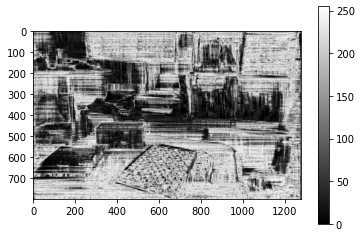

In [30]:
plt.imshow(conf_frame,cmap='gray')
plt.colorbar()

82
Wall time: 91.6 ms


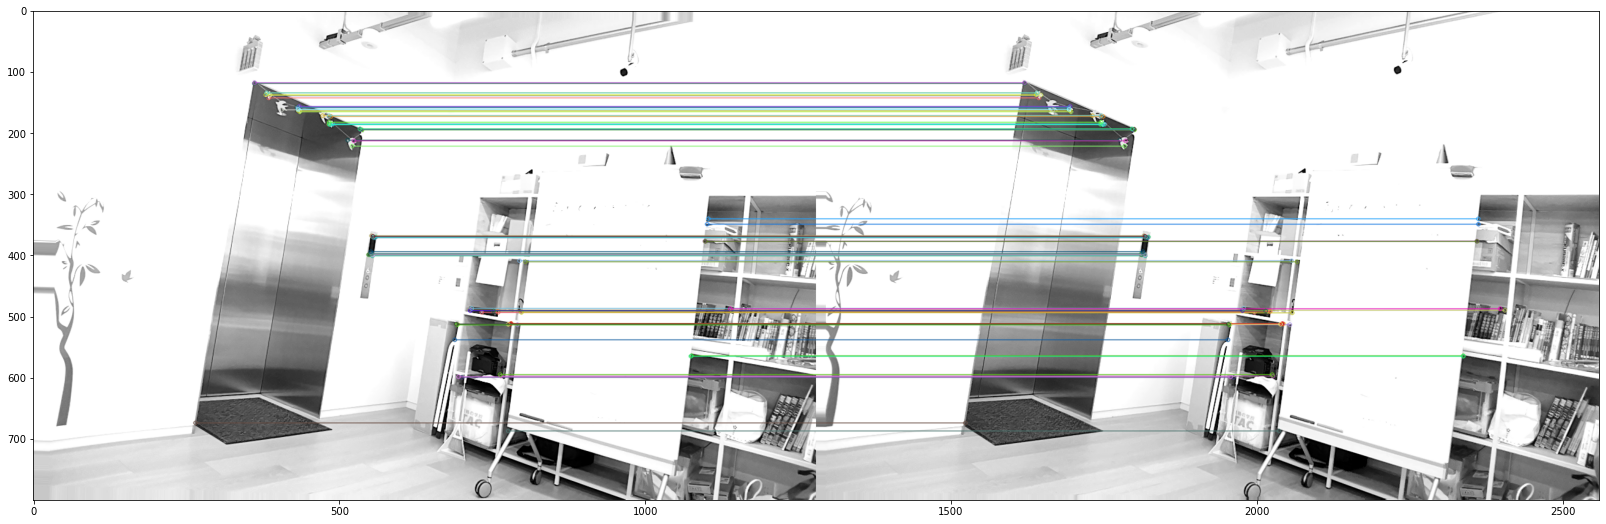

In [501]:
%%time
orb=cv2.ORB_create()
orb_left_kp, orb_des_left = orb.detectAndCompute(left_frame, None)
orb_right_kp, orb_des_right = orb.detectAndCompute(right_frame, None)
orb_bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
orb_matches = orb_bf.match(orb_des_left, orb_des_right)
orb_matches = [i for i in orb_matches if abs(orb_left_kp[i.queryIdx].pt[1]-orb_right_kp[i.trainIdx].pt[1])<1]
img3 = cv2.drawMatches(left_frame, orb_left_kp,right_frame,orb_right_kp,orb_matches,None,flags=2)
print(len(orb_matches))
plt.figure(figsize=(32,9))
plt.imshow(img3)

In [152]:
next_akaze_left_kp, next_akaze_des_left = akaze.detectAndCompute(next_left_frame,None)
next_akaze_right_kp, next_akaze_des_right = akaze.detectAndCompute(next_right_frame,None)
next_akaze_matches = bf.match(next_akaze_des_left, next_akaze_des_right)
next_akaze_matches = [i for i in next_akaze_matches if abs(next_akaze_left_kp[i.queryIdx].pt[1]-next_akaze_right_kp[i.trainIdx].pt[1])<1]


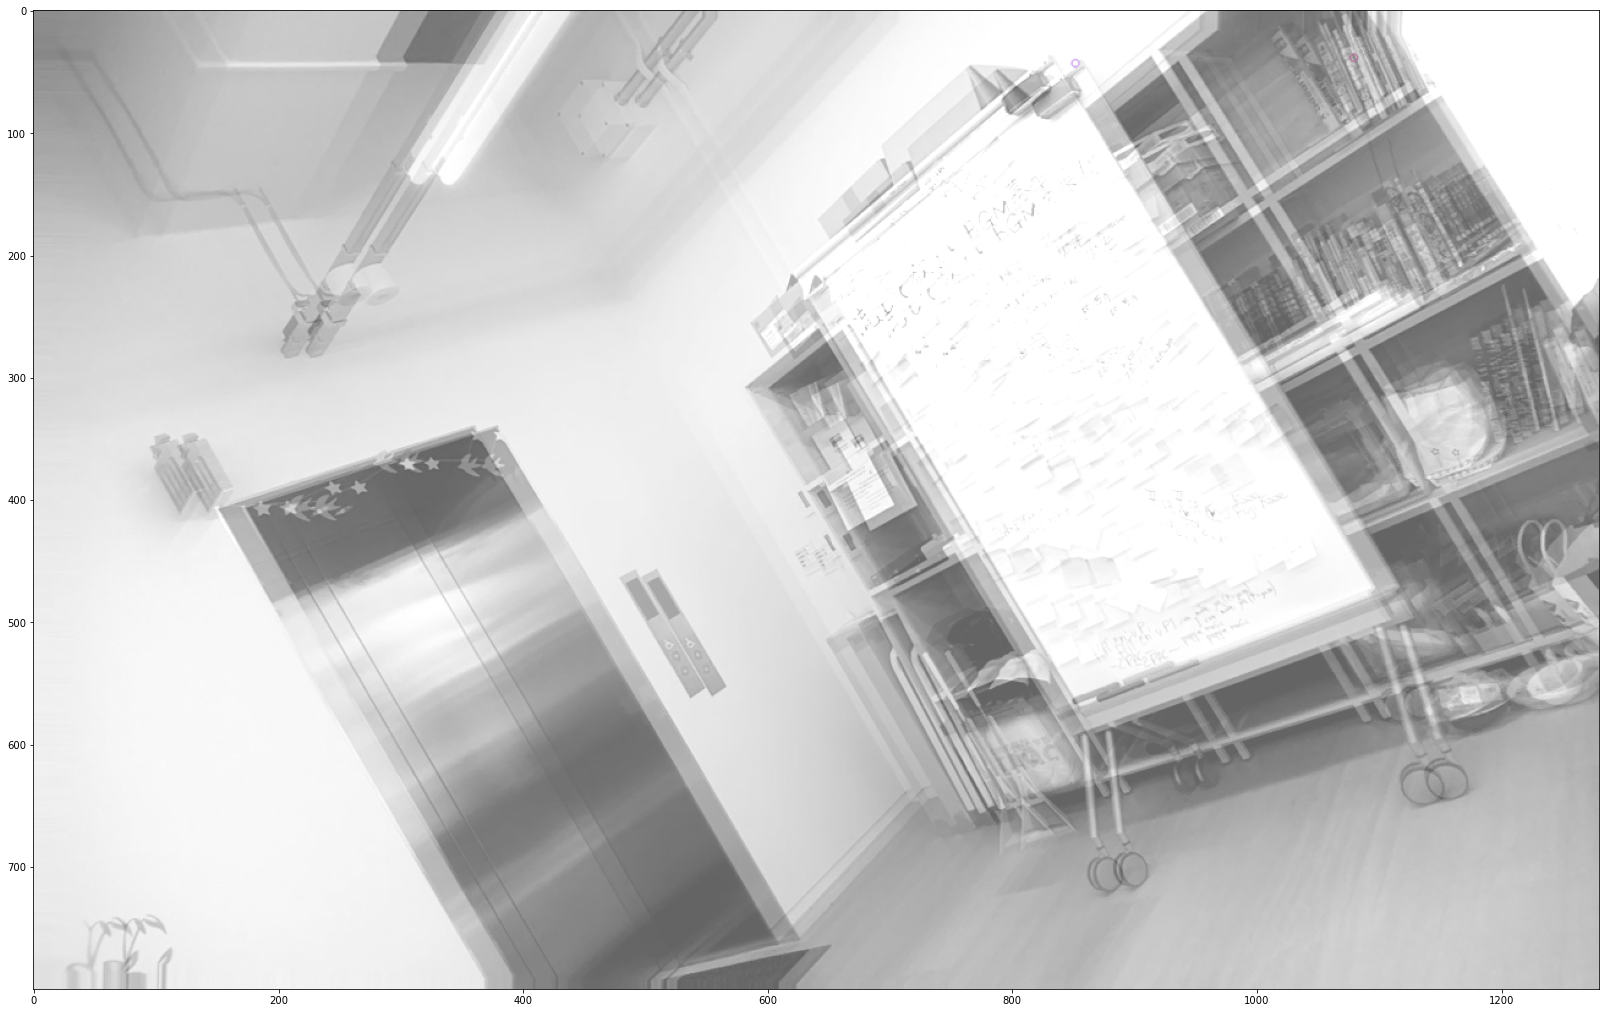

In [179]:
blend=cv2.addWeighted(left_frame, 0.4, right_frame, 0.4, 100)
i=11
blend= cv2.drawKeypoints(blend,akaze_left_kp[i:i+1],None,flags=2)
blend= cv2.drawKeypoints(blend,akaze_right_kp[i:i+1],None,flags=2)

# y= 470
# cv2.line(blend, (0, y), (1280, y), (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
plt.figure(figsize=(32,18))
plt.imshow(blend,cmap = "gray",)

(800, 1280)

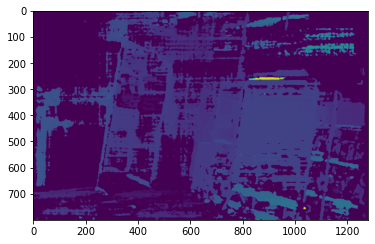

In [70]:
# 視差は左から右を引いたもの
plt.imshow(dis_frame)
dis_frame.shape

In [615]:
35*(0.90000000000000000000**3)

25.515000000000004

In [616]:
7*6/2/1

21.0

In [617]:
21.0*(0.90000000000000000000**2)*0.1

1.7010000000000003

In [44]:
all_des = np.array([])
for i in range(0,10):
    sift=np.load(f"./SIFT/frame{i}.npz")
#     sift_pos=sift['positions']
    sift_des=sift["right_descriptions"]
    if i == 0:
        all_des = sift_des
    else:
        all_des = np.concatenate([all_des,sift_des])

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [45]:
all_des.shape

(6451, 128)

100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


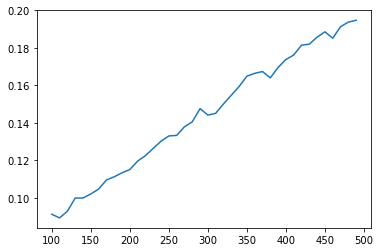

In [46]:
scorelist =[]
klist = []
for i in range(100,500,10):
    print(i)
    k =i
    kmeans = KMeans(n_clusters=k)
    y = kmeans.fit_predict(all_des)
    s = silhouette_score(all_des,kmeans.labels_)
    scorelist.append(s)
    klist.append(i)
plt.plot(klist , scorelist)

0.06170697